230209

Rober

y1' = -k1*y1 + k3*y2*y3

y2' = k1*y1 - k2*y2**2 - k3*y2*y3

y3' = k2*y2**2

k1, k2, k3 = 0.04, 3*10 ** 7, 10 ** 4

t 범위는 [0, 40]

bias = [1, 0, 0]

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from openpyxl import Workbook
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
def Rober_x(n = 20):
    x = np.linspace(0, 40, n).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    return x

def Rober_y(x, w, idx, bias): 
    '''
        y1(x) = bias[idx] + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    w = w.v[idx]
    n = w.shape[0]

    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y

def Rober_loss(x, w, bias, k1, k2, k3):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y1, y2, y3 = [Rober_y(x, w, idx = idx, bias = b) for idx, b in enumerate(bias)]
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)
        d_y3 = tape.gradient(y3, x)

        # y1' = -k1*y1 + k3*y2*y3
        # y2' = k1*y1 - k2*y2**2 - k3*y2*y3
        # y3' = k2*y2**2
        loss_1 = d_y1 - (-k1*y1 + k3*y2*y3)
        loss_2 = d_y2 - (k1*y1 - k2*y2**2 - k3*y2*y3)
        loss_3 = d_y3 - (k2*y2**2)
        square_loss = tf.add_n([tf.square(loss_1), tf.square(loss_2), tf.square(loss_3)])
        total_loss = tf.reduce_mean(square_loss)

        grad_w = tape.gradient(total_loss, w.trainable_variables)
    return grad_w, total_loss

def Rober_w(w_n, bias, k1, k2, k3, n = 20):
    # custom train_x
    train_x = Rober_x(n = n)

    learning_rate = 1e-5
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(len(bias), w_n), dtype=tf.float32))

    print('Start Rober : {}차'.format(w_n))
    save_loss = 0
    for itr in range(10001):
        # custom loss
        grad_w, total_loss = Rober_loss(train_x, w, bias, k1, k2, k3)
        optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    return w

In [4]:
w_1 = Rober_w(w_n = 1, n = 20, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)
w_2 = Rober_w(w_n = 2, n = 20, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)
w_3 = Rober_w(w_n = 3, n = 20, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)

Start Rober : 1차
iter : 0, y_loss : 248865584.0
iter : 5000, y_loss : 185176288.0
iter : 10000, y_loss : 135854320.0
Start Rober : 2차
iter : 0, y_loss : 2508813877903360.0
iter : 5000, y_loss : 2052049072029696.0
iter : 10000, y_loss : 1664648524857344.0
Start Rober : 3차
iter : 0, y_loss : 547778518319104.0
iter : 5000, y_loss : 3085165920256.0
iter : 10000, y_loss : 1917152395264.0


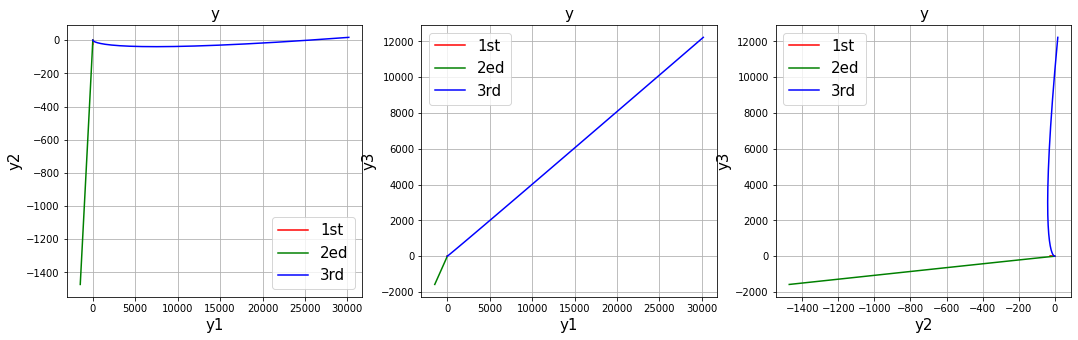

In [6]:
# show_graph
bias = [1, 0, 0]
test_x = Rober_x()
train_x = Rober_x()

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)

y11, y12, y13 = [Rober_y(test_x, w_1, idx = idx, bias = b) for idx, b in enumerate(bias)]
y21, y22, y23 = [Rober_y(test_x, w_2, idx = idx, bias = b) for idx, b in enumerate(bias)]
y31, y32, y33 = [Rober_y(test_x, w_3, idx = idx, bias = b) for idx, b in enumerate(bias)]

ax.plot(y11, y12, '-r', label = '1st')
ax.plot(y21, y22, '-g', label = '2ed')
ax.plot(y31, y32, '-b', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

ax2 = fig.add_subplot(132)
ax2.plot(y11, y13, '-r', label = '1st')
ax2.plot(y21, y23, '-g', label = '2ed')
ax2.plot(y31, y33, '-b', label = '3rd')
ax2.set_xlabel('y1', fontsize=15)
ax2.set_ylabel('y3', fontsize=15)
ax2.set_title('y', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(y12, y13, '-r', label = '1st')
ax3.plot(y22, y23, '-g', label = '2ed')
ax3.plot(y32, y33, '-b', label = '3rd')
ax3.set_xlabel('y2', fontsize=15)
ax3.set_ylabel('y3', fontsize=15)
ax3.set_title('y', fontsize=15)
ax3.tick_params(labelsize=10)
ax3.legend(fontsize=15)
ax3.grid()

In [14]:
def model_create(n):
    model_dic = dict()
    for i in range(1, n+1):
        model_dic['model_{}'.format(i)] = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])
        
    return model_dic

def Rober_y_EC(x, w, NN, idx, bias):
    '''
        y1(x) = bias[idx] + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y1_NN(x)*x
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y2_NN(x)*x
    '''
    y = bias[idx]
    w = w.v[idx]
    n = w.shape[0]
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y + NN[idx](x)*x

def Rober_y_EC_loss(x, w, y_NN, bias, k1, k2, k3):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        
        y1, y2, y3 = [Rober_y_EC(x, w, y_NN, idx, bias) for idx in range(len(bias))]
        
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)
        d_y3 = tape.gradient(y3, x)

        # y1' = -k1*y1 + k3*y2*y3
        # y2' = k1*y1 - k2*y2**2 - k3*y2*y3
        # y3' = k2*y2**2
        loss_1 = d_y1 - (-k1*y1 + k3*y2*y3)
        loss_2 = d_y2 - (k1*y1 - k2*y2**2 - k3*y2*y3)
        loss_3 = d_y3 - (k2*y2**2)

    square_loss = tf.square(loss_1) + tf.square(loss_2) + tf.square(loss_3)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def Rober_EC_train(w, bias, k1, k2, k3):
    # custom train_x
    x = Rober_x(n = 20)

    learning_rate = 1e-5    # 3 -> 5
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # custom model
    model_dic = model_create(n=len(bias))
    y_NN = list(model_dic.values())

    save_loss = 0
    for itr in range(100001):   # 10,000 -> 100,000
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)

            # custom loss
            total_loss = Rober_y_EC_loss(x, w, y_NN, bias, k1, k2, k3)
            grad_y = tape.gradient(total_loss, [model.trainable_variables for model in y_NN])
        
        for grad, model in zip(grad_y, y_NN):
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

        if itr % 50000 == 0:
            print('iter : {}, Rober_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
            
    return y_NN

In [8]:
# show_graph
bias = [1, 0, 0]
test_x = Rober_x()
train_x = Rober_x()

print('start w1 EC')
y1_NN = Rober_EC_train(w_1, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)
print('start w2 EC')
y2_NN = Rober_EC_train(w_2, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)
print('start w3 EC')
y3_NN = Rober_EC_train(w_3, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)

start w1 EC
iter : 0, Rober_y_total_loss : 397715456.0
iter : 5000, Rober_y_total_loss : 0.6788245439529419
iter : 10000, Rober_y_total_loss : 0.14281263947486877
iter : 15000, Rober_y_total_loss : 0.0032607957255095243
iter : 20000, Rober_y_total_loss : 7.149188604671508e-05
iter : 25000, Rober_y_total_loss : 1.1247439033468254e-05
iter : 30000, Rober_y_total_loss : 202.9470977783203
iter : 35000, Rober_y_total_loss : 0.6569069027900696
iter : 40000, Rober_y_total_loss : 0.3600248396396637
iter : 45000, Rober_y_total_loss : 0.015160515904426575
iter : 50000, Rober_y_total_loss : 0.0003375931119080633
iter : 55000, Rober_y_total_loss : 1.1990536222583614e-05
iter : 60000, Rober_y_total_loss : 8.820853508950677e-06
iter : 65000, Rober_y_total_loss : 0.18929007649421692
iter : 70000, Rober_y_total_loss : 0.0005734008736908436
iter : 75000, Rober_y_total_loss : 1.0651996490196325e-05
iter : 80000, Rober_y_total_loss : 2.1714131435146555e-06
iter : 85000, Rober_y_total_loss : 1.73124021785

Text(0.5, 1.0, 'y')

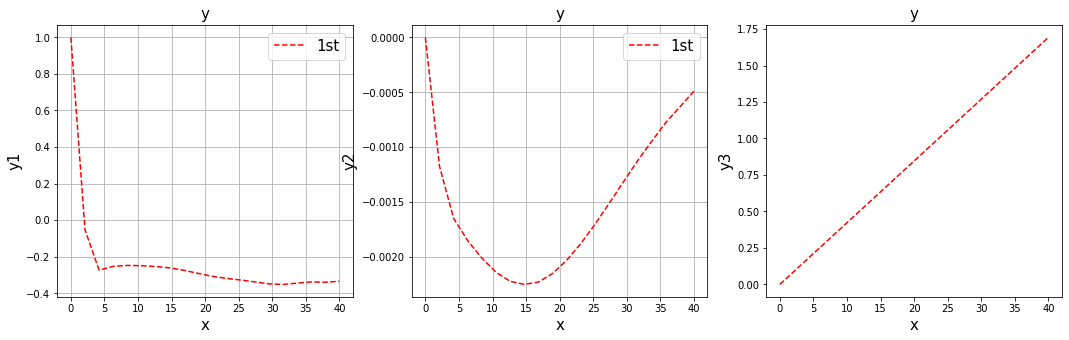

In [13]:
y11_EC, y12_EC, y13_EC = [Rober_y_EC(test_x, w_1, y1_NN, idx, bias) for idx in range(len(bias))]
y21_EC, y22_EC, y23_EC = [Rober_y_EC(test_x, w_2, y2_NN, idx, bias) for idx in range(len(bias))]
y31_EC, y32_EC, y33_EC = [Rober_y_EC(test_x, w_3, y3_NN, idx, bias) for idx in range(len(bias))]

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)


ax.plot(test_x, y11_EC, '--r', label = '1st')
# ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
# ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y1', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

ax2 = fig.add_subplot(132)
ax2.plot(test_x, y12_EC, '--r', label = '1st')
# ax2.plot(y21_EC, y23_EC, '--b', label = '2ed')
# ax2.plot(y31_EC, y33_EC, '--g', label = '3rd')
ax2.set_xlabel('x', fontsize=15)
ax2.set_ylabel('y2', fontsize=15)
ax2.set_title('y', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(test_x, y13_EC, '--r', label = '1st')
# ax3.plot(y22_EC, y23_EC, '--b', label = '2ed')
# ax3.plot(y32_EC, y33_EC, '--g', label = '3rd')
ax3.set_xlabel('x', fontsize=15)
ax3.set_ylabel('y3', fontsize=15)
ax3.set_title('y', fontsize=15)


# ax.plot(y11_EC, y12_EC, '--r', label = '1st')
# # ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
# # ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
# ax.set_xlabel('y1', fontsize=15)
# ax.set_ylabel('y2', fontsize=15)
# ax.set_title('y', fontsize=15)
# ax.tick_params(labelsize=10)
# ax.legend(fontsize=15)
# ax.grid()

# ax2 = fig.add_subplot(132)
# ax2.plot(y11_EC, y13_EC, '--r', label = '1st')
# # ax2.plot(y21_EC, y23_EC, '--b', label = '2ed')
# # ax2.plot(y31_EC, y33_EC, '--g', label = '3rd')
# ax2.set_xlabel('y1', fontsize=15)
# ax2.set_ylabel('y3', fontsize=15)
# ax2.set_title('y', fontsize=15)
# ax2.tick_params(labelsize=10)
# ax2.legend(fontsize=15)
# ax2.grid()

# ax3 = fig.add_subplot(133)
# ax3.plot(y12_EC, y13_EC, '--r', label = '1st')
# # ax3.plot(y22_EC, y23_EC, '--b', label = '2ed')
# # ax3.plot(y32_EC, y33_EC, '--g', label = '3rd')
# ax3.set_xlabel('y2', fontsize=15)
# ax3.set_ylabel('y3', fontsize=15)
# ax3.set_title('y', fontsize=15)
# ax3.tick_params(labelsize=10)
# ax3.legend(fontsize=15)
# ax3.grid()

In [15]:
y1_NN = Rober_EC_train(w_1, bias = [1, 0, 0], k1 = 0.04, k2 = 3*10, k3 = 10)

iter : 0, Rober_y_total_loss : 188880928.0
iter : 50000, Rober_y_total_loss : 2.2026484657544643e-05
iter : 100000, Rober_y_total_loss : 8.638309736852534e-06


Text(0.5, 1.0, 'y')

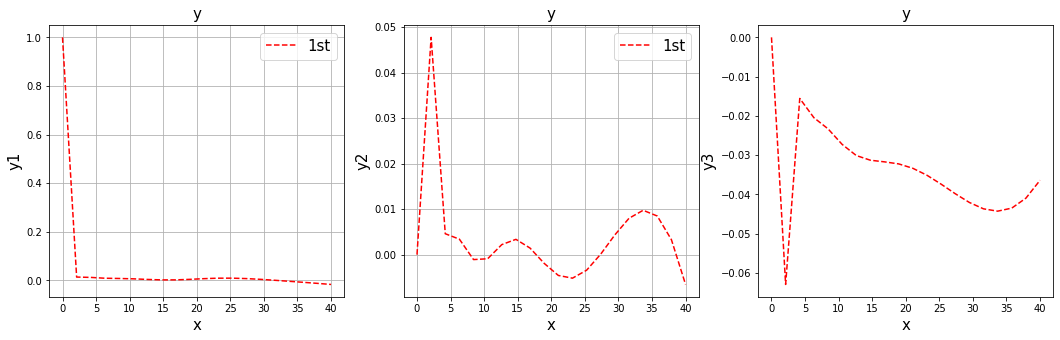

In [16]:
y11_EC, y12_EC, y13_EC = [Rober_y_EC(test_x, w_1, y1_NN, idx, bias) for idx in range(len(bias))]
# y21_EC, y22_EC, y23_EC = [Rober_y_EC(test_x, w_2, y2_NN, idx, bias) for idx in range(len(bias))]
# y31_EC, y32_EC, y33_EC = [Rober_y_EC(test_x, w_3, y3_NN, idx, bias) for idx in range(len(bias))]

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)


ax.plot(test_x, y11_EC, '--r', label = '1st')
# ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
# ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y1', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

ax2 = fig.add_subplot(132)
ax2.plot(test_x, y12_EC, '--r', label = '1st')
# ax2.plot(y21_EC, y23_EC, '--b', label = '2ed')
# ax2.plot(y31_EC, y33_EC, '--g', label = '3rd')
ax2.set_xlabel('x', fontsize=15)
ax2.set_ylabel('y2', fontsize=15)
ax2.set_title('y', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(test_x, y13_EC, '--r', label = '1st')
# ax3.plot(y22_EC, y23_EC, '--b', label = '2ed')
# ax3.plot(y32_EC, y33_EC, '--g', label = '3rd')
ax3.set_xlabel('x', fontsize=15)
ax3.set_ylabel('y3', fontsize=15)
ax3.set_title('y', fontsize=15)